# Training & Predicting with Betting-Enhanced Pre-match Features
Below, we extend our previous 7 pre-match features (historical stats) by incorporating **betting-related features**:

1. **Implied Probabilities** (`Implied_Prob_H`, `Implied_Prob_D`, `Implied_Prob_A`)
2. **Odds Confidence** (`Odds_Confidence`)
3. **Over/Under 2.5 Goal Probabilities** (`Over2.5_Prob`, `Under2.5_Prob`)
4. **Expected Goals (from Over/Under)** (`Expected_Goals`)
5. **Asian Handicap Probability** (`AH_Prob_H`, `AH_Prob_A`, plus `AHh`)
6. **(Optional) Betting Market Discrepancy** (`Market_Expectation`, etc.)

All of these are known **pre-match** (assuming you have odds data), so they can be safely used in your predictive model without leakage.

In [1]:
!pip install xgboost tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 82.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 58.6 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

2025-02-16 12:00:23.905399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 12:00:23.926098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 12:00:24.375453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 12:00:24.850490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739707225.444283   29756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739707225.60

In [3]:
import tensorflow as tf
tf.version.VERSION

'2.18.0'

## Preprocessing Function
This function:
1. Creates the **historical features** (home/away average goals, win %, etc.).
2. Encodes team names and final result (FTR) with label encoders.
3. Creates new **betting features** from the relevant columns. **We assume** your DataFrame `data` has the following columns:
   - `AvgH`, `AvgD`, `AvgA` (Average 1x2 odds)
   - `Avg>2.5`, `Avg<2.5` (Over/Under 2.5 odds)
   - `AvgAHH`, `AvgAHA`, `AHh` (Asian Handicap odds + handicap line)

In [4]:
def preprocess_data(data):
    # This is where we will preprocess the data and create some new features 
    # by calculating them given the stats we have in this dataset
    # Ensure HomeTeam & AwayTeam are string
    data['HomeTeam'] = data['HomeTeam'].astype(str)
    data['AwayTeam'] = data['AwayTeam'].astype(str)

    # -----------------------------
    # Create Historical Features
    # -----------------------------
    # (Requires known post-match data for older matches, used to calculate historical averages)
    data['HomeGoalsAvg'] = data.groupby('HomeTeam')['FTHG'].transform('mean')
    data['AwayGoalsAvg'] = data.groupby('AwayTeam')['FTAG'].transform('mean')
    data['HomeWinPct']   = data.groupby('HomeTeam')['FTR'].transform(lambda x: (x == 'H').mean())
    data['AwayWinPct']   = data.groupby('AwayTeam')['FTR'].transform(lambda x: (x == 'A').mean())
    data['GoalDifference'] = data['HomeGoalsAvg'] - data['AwayGoalsAvg']

    # ------------------------------------------------
    # Create Betting Features from Pre-Match Odds
    # ------------------------------------------------
    # Make sure we don't divide by zero
    # Replace any 0 or missing odds with NaN to avoid `inf`` issues
    odds_columns = ['AvgH','AvgD','AvgA', 'Avg>2.5','Avg<2.5', 'AvgAHH','AvgAHA']
    for col in odds_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = data[col].replace(0, np.nan)

    # --- Core Implied Probabilities (1 / odds) ---
    if all(x in data.columns for x in ['AvgH','AvgD','AvgA']):
        data['Implied_Prob_H'] = 1 / data['AvgH']
        data['Implied_Prob_D'] = 1 / data['AvgD']
        data['Implied_Prob_A'] = 1 / data['AvgA']
        # Confidence = max implied probability
        data['Odds_Confidence'] = data[['Implied_Prob_H','Implied_Prob_D','Implied_Prob_A']].max(axis=1)
    else:
        data['Implied_Prob_H'] = np.nan
        data['Implied_Prob_D'] = np.nan
        data['Implied_Prob_A'] = np.nan
        data['Odds_Confidence'] = np.nan

    # --- Over/Under 2.5 Probabilities ---
    if all(x in data.columns for x in ['Avg>2.5','Avg<2.5']):
        data['Over2.5_Prob']  = 1 / data['Avg>2.5']
        data['Under2.5_Prob'] = 1 / data['Avg<2.5']
        data['Expected_Goals'] = data['Over2.5_Prob'] - data['Under2.5_Prob']
    else:
        data['Over2.5_Prob']  = np.nan
        data['Under2.5_Prob'] = np.nan
        data['Expected_Goals'] = np.nan

    # --- Asian Handicap Probabilities ---
    if all(x in data.columns for x in ['AvgAHH','AvgAHA']):
        data['AH_Prob_H'] = 1 / data['AvgAHH']
        data['AH_Prob_A'] = 1 / data['AvgAHA']
    else:
        data['AH_Prob_H'] = np.nan
        data['AH_Prob_A'] = np.nan

    # data['AHh'] should already exist as the handicap line.
    # If not, set default.
    if 'AHh' not in data.columns:
        data['AHh'] = 0.0

    # -----------------------------
    # Market Discrepancy - just a possible measure, but not sure
    # -----------------------------
    # Market_Expectation = Implied_Prob_H * 3 - 1

    # Multiplying by 3 is just a simplified stand-in for “typical” home odds (e.g., if 
    # average home odds are around 3.00, that’s a break-even point).
    # Subtracting 1 adjusts it so that a positive value implies the market is “overrating” the 
    # home team (believing the home team is more likely to win than 
    # a neutral baseline would suggest), whereas a negative value implies the market 
    # is “underrating” the home team.
    if 'Implied_Prob_H' in data.columns:
        data['Market_Expectation'] = data['Implied_Prob_H'] * 3 - 1
    else:
        data['Market_Expectation'] = np.nan

    # -----------------------------
    # Encode Teams & Result
    # -----------------------------
    unique_teams = pd.concat([data['HomeTeam'], data['AwayTeam']]).unique()
    team_encoder = LabelEncoder()
    team_encoder.fit(unique_teams)

    data['HomeTeam'] = team_encoder.transform(data['HomeTeam'])
    data['AwayTeam'] = team_encoder.transform(data['AwayTeam'])

    joblib.dump(team_encoder, 'team_encoder.pkl')

    # Encode final result FTR: 0=H, 1=D, 2=A
    ftr_encoder = LabelEncoder()
    data['FTR'] = ftr_encoder.fit_transform(data['FTR'])
    joblib.dump(ftr_encoder, 'ftr_encoder.pkl')

    # Fill any missing values
    data.fillna(0, inplace=True)

    return data, team_encoder

## Load Dataset & Preprocess
We call `preprocess_data` which:
- Creates historical stats (goals, win %) 
- Adds the various **betting features** from the relevant columns
- Label-encodes teams and results

In [5]:
# Adjust the path accordingly (i.e. in Jupyter_notebooks/data/)
file_path = './data/full_dataset.csv'
raw_data = pd.read_csv(file_path)

normalised_data, label_encoder = preprocess_data(raw_data)
normalised_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Implied_Prob_H,Implied_Prob_D,Implied_Prob_A,Odds_Confidence,Over2.5_Prob,Under2.5_Prob,Expected_Goals,AH_Prob_H,AH_Prob_A,Market_Expectation
0,E0,16/08/2024,20:00,16,9,1,0,2,0,0,...,0.617284,0.229358,0.194175,0.617284,0.653595,0.396825,0.256769,0.492611,0.540541,0.851852
1,E0,17/08/2024,12:30,10,13,0,2,0,0,0,...,0.120773,0.173611,0.746269,0.746269,0.709220,0.340136,0.369084,0.507614,0.526316,-0.637681
2,E0,17/08/2024,15:00,0,26,2,0,2,1,0,...,0.847458,0.127226,0.063012,0.847458,0.684932,0.370370,0.314561,0.526316,0.510204,1.542373
3,E0,17/08/2024,15:00,8,4,0,3,0,0,1,...,0.374532,0.293255,0.373134,0.374532,0.552486,0.490196,0.062290,0.515464,0.515464,0.123596
4,E0,17/08/2024,15:00,17,21,1,0,2,1,0,...,0.740741,0.177936,0.123457,0.740741,0.714286,0.332226,0.382060,0.518135,0.518135,1.222222


## Select **Pre-match** Features & Prepare for Training
Below, we combine our **original 7 historical features** + the **betting features** that we just created.  

If you want to skip any feature comment it out from the list.

In [6]:
features = [
    # Historical features:
    'HomeTeam', 'AwayTeam',
    'HomeGoalsAvg', 
    #'AwayGoalsAvg',
    'HomeWinPct', 'AwayWinPct',
    'GoalDifference',
    # Betting features:
    #'Implied_Prob_H', 'Implied_Prob_D', 
    'Implied_Prob_A',
   # 'Odds_Confidence',
  #  'Over2.5_Prob', 'Under2.5_Prob', 
    'Expected_Goals',
   # 'AH_Prob_H', 'AH_Prob_A', 'AHh',
    'Market_Expectation'  # optional
]

# We'll train on all matches for which these columns are available.
X = normalised_data[features]
y = normalised_data['FTR']  # 0=H, 1=D, 2=A

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')

print('Shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (1679, 9) (420, 9) (1679,) (420,)


Random Forest Accuracy on Test Set: 0.488

Classification Report (Random Forest):
              precision    recall  f1-score   support

    Home Win       0.56      0.42      0.48       139
        Draw       0.21      0.13      0.16        98
    Away Win       0.53      0.73      0.61       183

    accuracy                           0.49       420
   macro avg       0.43      0.43      0.42       420
weighted avg       0.46      0.49      0.46       420



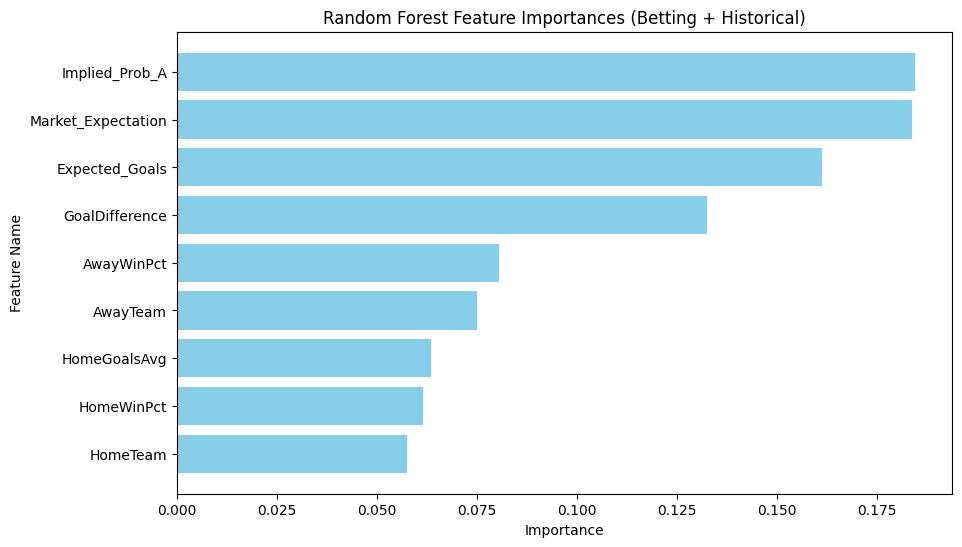

,Feature,Importance
6,Implied_Prob_A,0.184513
8,Market_Expectation,0.183766
7,Expected_Goals,0.161290
5,GoalDifference,0.132465
4,AwayWinPct,0.080569
1,AwayTeam,0.075023
2,HomeGoalsAvg,0.063417
3,HomeWinPct,0.061534
0,HomeTeam,0.057424


In [ ]:
# Random Forest + feature importance for Betting-Enhanced features

# Train a Random Forest on all features (including betting features).
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate performance on the test set
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy on Test Set: {rf_accuracy:.3f}\n")

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Home Win', 'Draw', 'Away Win']))

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title("Random Forest Feature Importances (Betting + Historical)")
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.show()

importance_df


## Train Multiple Classical Models
We’ll compare LogisticRegression, RandomForest, KNN, SVM, and XGBoost on these **enhanced** features.

In [ ]:
models = {
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN':                KNeighborsClassifier(n_neighbors=5),
    'SVM':                SVC(probability=True),
    'XGBoost':            XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    # KNN & SVM typically benefit from scaling, others can handle unscaled
    if name in ['KNN', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Report': classification_report(y_test, y_pred, target_names=['Home Win', 'Draw', 'Away Win'])
    }

    print(f"{name} Accuracy: {accuracy:.3f}")
    print(results[name]['Report'])


Random Forest Accuracy: 0.488
              precision    recall  f1-score   support

    Home Win       0.56      0.42      0.48       139
        Draw       0.21      0.13      0.16        98
    Away Win       0.53      0.73      0.61       183

    accuracy                           0.49       420
   macro avg       0.43      0.43      0.42       420
weighted avg       0.46      0.49      0.46       420

KNN Accuracy: 0.460
              precision    recall  f1-score   support

    Home Win       0.45      0.45      0.45       139
        Draw       0.25      0.22      0.24        98
    Away Win       0.56      0.60      0.58       183

    accuracy                           0.46       420
   macro avg       0.42      0.42      0.42       420
weighted avg       0.45      0.46      0.45       420



/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/p

SVM Accuracy: 0.536
              precision    recall  f1-score   support

    Home Win       0.55      0.52      0.53       139
        Draw       0.00      0.00      0.00        98
    Away Win       0.53      0.84      0.65       183

    accuracy                           0.54       420
   macro avg       0.36      0.45      0.39       420
weighted avg       0.41      0.54      0.46       420

XGBoost Accuracy: 0.464
              precision    recall  f1-score   support

    Home Win       0.48      0.43      0.45       139
        Draw       0.23      0.14      0.18        98
    Away Win       0.52      0.66      0.58       183

    accuracy                           0.46       420
   macro avg       0.41      0.41      0.40       420
weighted avg       0.44      0.46      0.44       420



### Pick the best model and save

In [9]:
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
best_model = results[best_model_name]['Model']

model_filename = f"{best_model_name.replace(' ', '_').lower()}_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Best model is {best_model_name} with accuracy {results[best_model_name]['Accuracy']:.3f}")

Best model is SVM with accuracy 0.536


## See which features determined the performance of the best model

In [10]:
import matplotlib.pyplot as plt

best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
best_model = results[best_model_name]['Model']

print(f"Best Model: {best_model_name}")

# Check if the model has a native 'feature_importances_' attribute (e.g., RandomForest, XGBoost)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = features  # same order as used in X
    
    # Create a DataFrame for easy sorting/plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()  # so highest importance is on top
    plt.title(f"Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.show()

# If Logistic Regression, we can interpret coefficients (especially if it's a single class vs. binary).
elif isinstance(best_model, LogisticRegression):
    # For multi-class (3 classes), 'coef_' will have shape (3, n_features).
    # We can average absolute coefficients across classes as a simple measure of importance.
    coefs = best_model.coef_
    abs_coefs_mean = coefs.mean(axis=0)  # or np.mean(np.abs(coefs), axis=0) if you prefer abs values
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Coefficient (Mean)': abs_coefs_mean
    }).sort_values('Coefficient (Mean)', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Coefficient (Mean)'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title("Logistic Regression Feature Importance (Mean Coefficient Magnitude)")
    plt.xlabel("Mean Coefficient (across classes)")
    plt.show()

# For KNN, SVM (non-linear kernel), or other models without straightforward importance measures:
else:
    print(f"No native feature_importances_ for {best_model_name}.")
    print("Consider using SHAP or Permutation Importance for model-agnostic explanations.")


Best Model: SVM
No native feature_importances_ for SVM.
Consider using SHAP or Permutation Importance for model-agnostic explanations.


## Neural Network
We can also train a **Keras** model using these **betting-enhanced** features.

In [ ]:
# Convert y to one-hot for the neural network
num_classes = len(np.unique(y))  # 3 for H, D, A
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh  = to_categorical(y_test,  num_classes=num_classes)

nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mse', 'mae']
)

history = nn_model.fit(
    X_train_scaled, y_train_oh,
    validation_split=0.2,
    epochs=9,
    batch_size=8,
    verbose=1
)

# Evaluate on test set
loss, acc, mse, mae = nn_model.evaluate(X_test_scaled, y_test_oh, verbose=0)
print(f"Neural Network Accuracy: {acc:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")

# Save the NN model
nn_model.save('nn_model.h5')

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-16 12:00:42.726000: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4844 - loss: 1.0326 - mae: 0.3959 - mse: 0.2059 - val_accuracy: 0.5565 - val_loss: 0.9624 - val_mae: 0.3883 - val_mse: 0.1906
Epoch 2/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5181 - loss: 1.0051 - mae: 0.3940 - mse: 0.1994 - val_accuracy: 0.5565 - val_loss: 0.9622 - val_mae: 0.3831 - val_mse: 0.1904
Epoch 3/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5507 - loss: 0.9623 - mae: 0.3768 - mse: 0.1901 - val_accuracy: 0.5536 - val_loss: 0.9630 - val_mae: 0.3834 - val_mse: 0.1908
Epoch 4/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5404 - loss: 0.9731 - mae: 0.3814 - mse: 0.1925 - val_accuracy: 0.5446 - val_loss: 0.9668 - val_mae: 0.3852 - val_mse: 0.1916
Epoch 5/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5317 - loss: 0.9732 - mae: 0.3797 - mse: 0.1918 - val_accuracy: 0.5565 - val_loss: 0.9605 - val_mae: 0.3840 - val_mse: 0.1903
Epoch 6/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

Neural Network Accuracy: 0.540, MSE: 0.190, MAE: 0.378


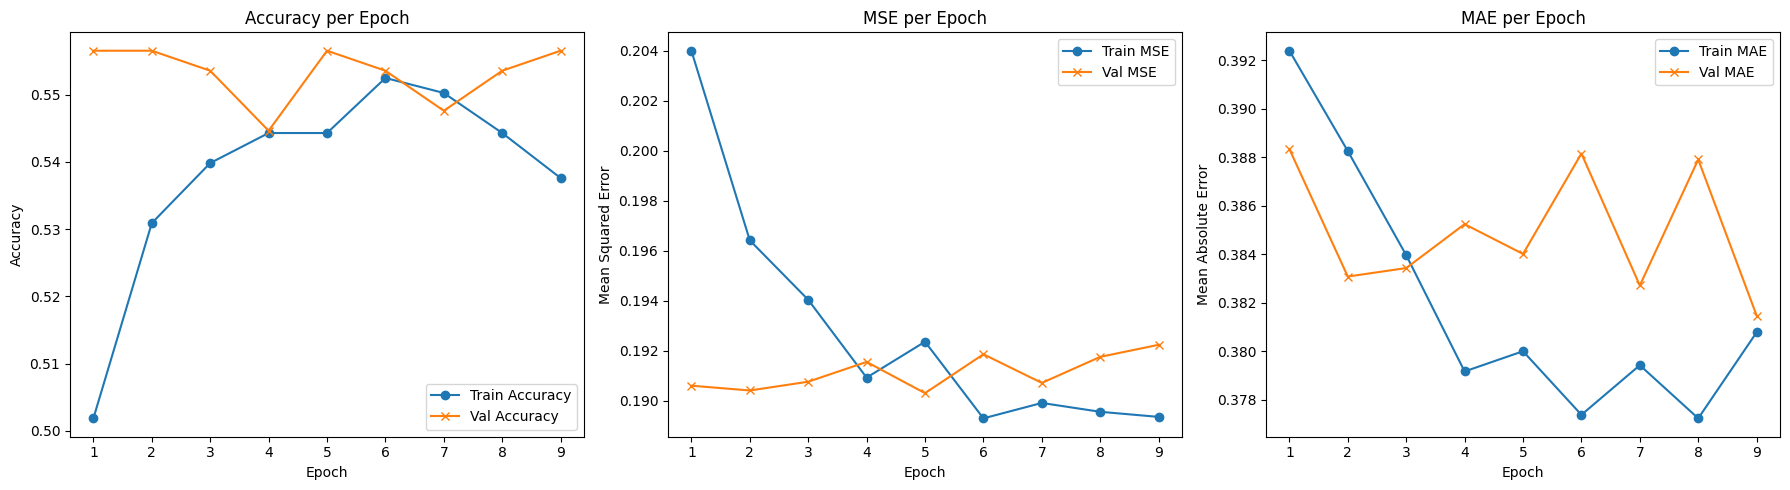

Neural Network - Final Test Metrics
  Loss: 0.961
  Accuracy: 0.540
  MSE: 0.190
  MAE: 0.378


In [12]:
# Plot accuracy, MSE, MAE by epoch
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']

train_mse = history.history['mse']
val_mse   = history.history['val_mse']

train_mae = history.history['mae']
val_mae   = history.history['val_mae']

epochs = range(1, len(train_acc) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -- Accuracy --
axes[0].plot(epochs, train_acc, label='Train Accuracy', marker='o')
axes[0].plot(epochs, val_acc,   label='Val Accuracy',   marker='x')
axes[0].set_title('Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# -- MSE --
axes[1].plot(epochs, train_mse, label='Train MSE', marker='o')
axes[1].plot(epochs, val_mse,   label='Val MSE',   marker='x')
axes[1].set_title('MSE per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Squared Error')
axes[1].legend()

# -- MAE --
axes[2].plot(epochs, train_mae, label='Train MAE', marker='o')
axes[2].plot(epochs, val_mae,   label='Val MAE',   marker='x')
axes[2].set_title('MAE per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Mean Absolute Error')
axes[2].legend()

plt.tight_layout()
plt.show()

# Final test metrics
loss, acc, mse, mae = nn_model.evaluate(X_test_scaled, y_test_oh, verbose=0)
print(f"Neural Network - Final Test Metrics")
print(f"  Loss: {loss:.3f}")
print(f"  Accuracy: {acc:.3f}")
print(f"  MSE: {mse:.3f}")
print(f"  MAE: {mae:.3f}")

## Prediction Functions for New Matches
This function shows how to do inference with the loaded model.  
**Important**: If you want to incorporate *live* betting odds for an upcoming match, you’ll need to pass those odds (AvgH, AvgA, etc.) directly rather than looking them up in the historical `normalised_data`.

Below is just an example that re-uses the historical row to fill in the columns. In real deployment, you’d supply new matches’ betting odds + historical stats and encode them similarly.

In [ ]:
def predict_match(
    home_team_str, away_team_str,
    model, scaler, team_encoder,
    is_nn=False
):

    # Check team existence
    if home_team_str not in team_encoder.classes_:
        raise ValueError(f"Unknown home team: {home_team_str}")
    if away_team_str not in team_encoder.classes_:
        raise ValueError(f"Unknown away team: {away_team_str}")

    home_encoded = team_encoder.transform([home_team_str])[0]
    away_encoded = team_encoder.transform([away_team_str])[0]

    home_rows = normalised_data[normalised_data['HomeTeam'] == home_encoded]
    away_rows = normalised_data[normalised_data['AwayTeam'] == away_encoded]

    if home_rows.empty or away_rows.empty:
        raise ValueError(
            f"Could not find historical data for {home_team_str} or {away_team_str}"
        )

    # Just pick the first row for each
    home_goals_avg = home_rows['HomeGoalsAvg'].iloc[0]
    away_goals_avg = away_rows['AwayGoalsAvg'].iloc[0]
    home_win_pct   = home_rows['HomeWinPct'].iloc[0]
    away_win_pct   = away_rows['AwayWinPct'].iloc[0]
    goal_diff      = home_goals_avg - away_goals_avg

    # using implied probability taken from previous odds from bookies

    implied_prob_h = home_rows['Implied_Prob_H'].iloc[0]
    implied_prob_d = home_rows['Implied_Prob_D'].iloc[0]
    implied_prob_a = away_rows['Implied_Prob_A'].iloc[0]
    odds_conf      = max(implied_prob_h, implied_prob_d, implied_prob_a)

    over2_5_prob   = home_rows['Over2.5_Prob'].iloc[0]
    under2_5_prob  = home_rows['Under2.5_Prob'].iloc[0]
    expected_goals = home_rows['Expected_Goals'].iloc[0]

    ah_prob_h      = home_rows['AH_Prob_H'].iloc[0]
    ah_prob_a      = away_rows['AH_Prob_A'].iloc[0]
    ahh_line       = home_rows['AHh'].iloc[0]

    market_exp     = home_rows['Market_Expectation'].iloc[0]

    # Construct the feature array in same order as 'features'
    input_vector = np.array([
        home_encoded,
        away_encoded,
        home_win_pct,
        away_win_pct,
        goal_diff,
        implied_prob_a,
        odds_conf,
        expected_goals,
        market_exp
    ]).reshape(1, -1)

    # Scale it
    input_scaled = scaler.transform(input_vector)

    # Predict
    if is_nn:
        # Keras model -> returns probability distribution over 3 classes
        preds = model.predict(input_scaled, verbose=0)
        label_num = np.argmax(preds, axis=1)[0]
    else:
        label_num = model.predict(input_scaled)[0]

    mapping = {0: 'Home Win', 1: 'Draw', 2: 'Away Win'}
    return mapping[label_num]

## Example with test matches
Below is an example on real matches. The `actual_res` column covers matches 3rd Feb to 5th Feb.

In [14]:
# Reload the best classical model and the NN
best_classical_path = f"{best_model_name.replace(' ', '_').lower()}_model.pkl"
clf_model = joblib.load(best_classical_path)
print("Loaded classical model: " + best_model_name)

nn_model_loaded = tf.keras.models.load_model('nn_model.h5')

# Reload the scaler & team_encoder
scaler_loaded = joblib.load('scaler.pkl')
team_encoder_loaded = joblib.load('team_encoder.pkl')

# Some matches; 'actual_res'
matches = [
    ("Bournemouth", "Liverpool", "Away Win"),
    ("Everton", "Leicester", "Home Win"),
    ("Ipswich", "Southampton", "Away Win"), 
    ("Newcastle", "Fulham", "Away Win"),
    ("Man United", "Crystal Palace", "Away Win"),
    ("Arsenal", "Man City", "Home Win"),
    ("Chelsea", "West Ham", "Home Win"),
]

score = 0
for home_team, away_team, actual_res in matches:
    try:
        # Predict with classical model
        result = predict_match(
            home_team, away_team,
            clf_model,
            scaler_loaded,
            team_encoder_loaded,
            is_nn=False
        )
        correct = (result == actual_res)
        if correct:
            score += 1
        print(f"[CLASSICAL] {home_team} vs {away_team} -> Predicted: {result}, Actual: {actual_res}, Correct?: {correct}")
    except ValueError as e:
        print(e)

print("=" * 40)
print(f"Classical Model Correct Predictions: {score}/{len(matches)}\n")


Loaded classical model: SVM
[CLASSICAL] Bournemouth vs Liverpool -> Predicted: Away Win, Actual: Away Win, Correct?: True
[CLASSICAL] Everton vs Leicester -> Predicted: Away Win, Actual: Home Win, Correct?: False
[CLASSICAL] Ipswich vs Southampton -> Predicted: Away Win, Actual: Away Win, Correct?: True


[CLASSICAL] Newcastle vs Fulham -> Predicted: Home Win, Actual: Away Win, Correct?: False
[CLASSICAL] Man United vs Crystal Palace -> Predicted: Home Win, Actual: Away Win, Correct?: False
[CLASSICAL] Arsenal vs Man City -> Predicted: Away Win, Actual: Home Win, Correct?: False
[CLASSICAL] Chelsea vs West Ham -> Predicted: Home Win, Actual: Home Win, Correct?: True
Classical Model Correct Predictions: 3/7



/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/skl

In [15]:
# Now do it with the NN model
nn_score = 0
for home_team, away_team, actual_res in matches:
    try:
        nn_result = predict_match(
            home_team, away_team,
            nn_model_loaded,
            scaler_loaded,
            team_encoder_loaded,
            is_nn=True
        )
        correct = (nn_result == actual_res)
        if correct:
            nn_score += 1
        print(f"[NN] {home_team} vs {away_team} -> Predicted: {nn_result}, Actual: {actual_res}, Correct?: {correct}")
    except ValueError as e:
        print(e)

print("=" * 40)
print(f"NN Model Correct Predictions: {nn_score}/{len(matches)}")

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[NN] Bournemouth vs Liverpool -> Predicted: Away Win, Actual: Away Win, Correct?: True
[NN] Everton vs Leicester -> Predicted: Away Win, Actual: Home Win, Correct?: False
[NN] Ipswich vs Southampton -> Predicted: Away Win, Actual: Away Win, Correct?: True


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[NN] Newcastle vs Fulham -> Predicted: Home Win, Actual: Away Win, Correct?: False
[NN] Man United vs Crystal Palace -> Predicted: Home Win, Actual: Away Win, Correct?: False
[NN] Arsenal vs Man City -> Predicted: Home Win, Actual: Home Win, Correct?: True
[NN] Chelsea vs West Ham -> Predicted: Home Win, Actual: Home Win, Correct?: True
NN Model Correct Predictions: 4/7


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Production code

In [16]:
nn_model_loaded = tf.keras.models.load_model('nn_model.h5')

# Reload the scaler & team_encoder
scaler_loaded = joblib.load('scaler.pkl')
team_encoder_loaded = joblib.load('team_encoder.pkl')

In [17]:
home_team = "Arsenal"
away_team = "Chelsea"

In [18]:
# Now do it with the NN model
nn_result = predict_match(
    home_team, away_team,
    nn_model_loaded,
    scaler_loaded,
    team_encoder_loaded,
    is_nn=True
)
print(home_team, away_team, nn_result)

Arsenal Chelsea Home Win


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
